In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os

sys.path.append("../")

import torch

from data import chembldb, datasets
from training import trainer
from modules import simple_rnn
import datetime
import plots, utilities
from IPython.display import Image, display, Markdown

import torch


## First we load the SMILES strings representing the molecules in the CHEMBL database.

In [13]:
# the whole dataset is huge, so we only take every nth SMILES string
every_nth = 10
chembl_raw = chembldb.ChemblDBChemreps()
chembl_smiles = chembl_raw._load_or_download()["canonical_smiles"].to_list()[::every_nth]

In [14]:
# Chembl smiles contains a list of all the SMILES strings in the Chembl database.
chembl_smiles[:10]

['Cc1cc(-c2csc(N=C(N)N)n2)cn1C',
 'COc1ccc2c(c1OC)C(CC1(C)C=Cc3c(c4cccc(OC)c4n(C)c3=O)O1)N(C)c1c-2ccc2cc3c(cc12)OCO3',
 'N=c1sc2ccccc2n1CCN1CCC(c2ccc(F)cc2)CC1',
 'COC(=O)C[C@H]1C(C)(C)[C@H](OC(C)=O)[C@H]2C(=O)[C@]1(C)[C@H]1CC[C@]3(C)[C@@H](CC(=O)O[C@H]3c3ccoc3)[C@]13O[C@H]23',
 'CN1C(=O)[C@H](NC(=O)Nc2cccc(OCCNC(=O)COCC(=O)NNC(=O)COCC(=O)N[C@H]3CC[C@@]4(O)[C@H]5Cc6cc(O)cc7c6[C@@]4(CCN5C)[C@H]3O7)c2)N=C(c2ccccc2)c2ccccc21',
 'CSCC[C@H](NC(=O)[C@@H](CC(C)C)NC(=O)CNC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)CCCN=C(N)N)C(N)=O',
 'CNC(=O)c1cc(C(O)CNC(C)CCc2ccc3c(c2)OCO3)ccc1O.Cl',
 'CC(=O)NC(C(=O)N1CCSCC1)[C@H]1CC(C(=O)O)C[C@@H]1N=C(N)N',
 'CC[C@H](C)[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](C

In [15]:
chembl = datasets.CharacterLevelSMILES(
    smiles_list = chembl_smiles,
    length = 256, 
    batch_size = 128
)

## Next, lets define a model. We'll be using a character-level LSTM model to predict the next character in a SMILES string based on the previous characters.

In [16]:
model = simple_rnn.simpleLSTM(
    # Mandatory
    num_hiddens = 512,
    vocab_size = len(chembl.characters),
    # tuning
    learning_rate = 0.001,
    weight_decay = 1e-4,
    num_layers = 5,
    output_dropout=0.2,
    rnn_dropout=0.2,
)

In [17]:
load_model_path = "../models/character_level_rnn_generator.pth"

train_new = True  # Set false to load a pre-trained model
save_model = True  # If trainign a new model, do we want to save it?

if train_new:
    model_trainer = trainer.Trainer(max_epochs=16, init_random=None, clip_grads_norm=2.0)
    model_trainer.fit(model, chembl)

    if save_model:
        utilities.save_model_weights("Chembl-Mini-", model, chembl)
else: 
    model.load_weights(
        path = load_model_path,
    )
    device="cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

Epoch 1 completed in 113.83 seconds.6)
Epoch 1/16: Train Loss: 1.8948, Val Loss: 1.1113
Epoch 2 completed in 114.21 seconds.6)
Epoch 2/16: Train Loss: 1.0234, Val Loss: 0.9430
Epoch 3 completed in 114.34 seconds.6)
Epoch 3/16: Train Loss: 0.9187, Val Loss: 0.9263
Epoch 4 completed in 114.33 seconds.6)
Epoch 4/16: Train Loss: 0.8883, Val Loss: 0.8347
Epoch 5 completed in 114.29 seconds.6)
Epoch 5/16: Train Loss: 0.8610, Val Loss: 0.8258
Epoch 6 completed in 114.43 seconds.6)
Epoch 6/16: Train Loss: 0.8407, Val Loss: 0.9030
Epoch 7 completed in 114.34 seconds.6)
Epoch 7/16: Train Loss: 0.8160, Val Loss: 0.7972
Epoch 8 completed in 114.36 seconds.6)
Epoch 8/16: Train Loss: 0.8054, Val Loss: 0.7797
Epoch 9 completed in 114.43 seconds.6)
Epoch 9/16: Train Loss: 0.7928, Val Loss: 0.7730
Epoch 10 completed in 114.44 seconds.6)
Epoch 10/16: Train Loss: 0.7980, Val Loss: 0.7670
Epoch 11 completed in 114.40 seconds.6)
Epoch 11/16: Train Loss: 0.7950, Val Loss: 0.7649
Epoch 12 completed in 114.43

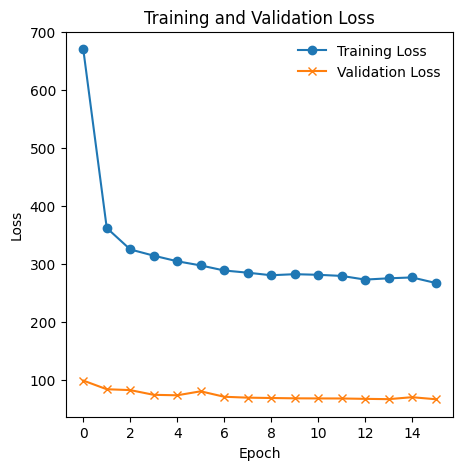

In [22]:
losses = utilities.extract_training_losses(
    metadata = model_trainer.metadata,
)
fig, ax = plots.plot_training_validation_loss(
    training_losses = losses["train_losses"],
    validation_losses = losses["val_losses"],
)

## Below, we ask the model to generate 20 totally random molecules, by providing it with an empty seed string.

In [23]:
n_chars = 100

n_valid = 0
n_invalid = 0
images = []
for i in range(20):
    output = simple_rnn.simple_generate(" ", n_chars, model, chembl.char_to_idx, chembl.idx_to_char, temperature=0.5, device='cuda')
    print(f"Requested up to {n_chars} characters, got: {len(output)}")
    print(f"Molecule Canonical SMILES: {output}")

    valid = utilities.validate_smiles_string(output)

    if not valid:
        n_invalid += 1
        print("Generated SMILES is not valid.")
    else:
        n_valid += 1
        print("Generated SMILES is valid.")
        images.append(utilities.draw_molecule(output))

Requested up to 100 characters, got: 101
Molecule Canonical SMILES:  CC(=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Generated SMILES is valid.
Requested up to 100 characters, got: 16
Molecule Canonical SMILES:  O(N)Cc1ccccc1Cl
Generated SMILES is valid.


Requested up to 100 characters, got: 101
Molecule Canonical SMILES:  CC(C)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Generated SMILES is valid.
Requested up to 100 characters, got: 25
Molecule Canonical SMILES:  OC(=O)Nc1ccccc1)c1ccccc1
Generated SMILES is not valid.
Requested up to 100 characters, got: 30
Molecule Canonical SMILES:  O(CCNC(=O)c1ccccc1Cl)N1CCOCC1
Generated SMILES is valid.


[09:32:05] SMILES Parse Error: extra close parentheses while parsing: OC(=O)Nc1ccccc1)c1ccccc1
[09:32:05] SMILES Parse Error: check for mistakes around position 16:
[09:32:05] OC(=O)Nc1ccccc1)c1ccccc1
[09:32:05] ~~~~~~~~~~~~~~~^
[09:32:05] SMILES Parse Error: Failed parsing SMILES ' OC(=O)Nc1ccccc1)c1ccccc1' for input: ' OC(=O)Nc1ccccc1)c1ccccc1'


Requested up to 100 characters, got: 85
Molecule Canonical SMILES:  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
Generated SMILES is valid.
Requested up to 100 characters, got: 31
Molecule Canonical SMILES:  Oc1cccc(Cl)c1)c1cccc(C(=O)O)c1
Generated SMILES is not valid.


[09:32:05] SMILES Parse Error: extra close parentheses while parsing: Oc1cccc(Cl)c1)c1cccc(C(=O)O)c1
[09:32:05] SMILES Parse Error: check for mistakes around position 14:
[09:32:05] Oc1cccc(Cl)c1)c1cccc(C(=O)O)c1
[09:32:05] ~~~~~~~~~~~~~^
[09:32:05] SMILES Parse Error: Failed parsing SMILES ' Oc1cccc(Cl)c1)c1cccc(C(=O)O)c1' for input: ' Oc1cccc(Cl)c1)c1cccc(C(=O)O)c1'


Requested up to 100 characters, got: 101
Molecule Canonical SMILES:  CC(C)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Generated SMILES is valid.
Requested up to 100 characters, got: 101
Molecule Canonical SMILES:  CC(C)CC(=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Generated SMILES is valid.
Requested up to 100 characters, got: 42
Molecule Canonical SMILES:  COc1ccc(NC(=O)CCN2CCN(c3ccccc3)CC2)c(C)c1
Generated SMILES is valid.
Requested up to 100 characters, got: 46
Molecule Canonical SMILES:  O=C(NCc1ccccc1)C(=O)N1CCC(C(=O)NCc2ccccc2)CC1
Generated SMILES is valid.
Requested up to 100 characters, got: 101
Molecule Canonical SMILES:  O(C(=O)O)C(=O)COC(=O)CNC(=O)[C@H](CCCCNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCN
Generated SMILES is not valid.
Requested up to 100 characters, got: 42
Molecule Canonical SMILES:  CC(C)CCN(CCCCN)C(=O)CCc1ccc(-c2ccccc2)cc1
Generated SMILES 

[09:32:07] SMILES Parse Error: extra open parentheses while parsing: O(C(=O)O)C(=O)COC(=O)CNC(=O)[C@H](CCCCNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCN
[09:32:07] SMILES Parse Error: check for mistakes around position 34:
[09:32:07] )COC(=O)CNC(=O)[C@H](CCCCNC(=O)[C@H](CCCN
[09:32:07] ~~~~~~~~~~~~~~~~~~~~^
[09:32:07] SMILES Parse Error: extra open parentheses while parsing: O(C(=O)O)C(=O)COC(=O)CNC(=O)[C@H](CCCCNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCN
[09:32:07] SMILES Parse Error: check for mistakes around position 96:
[09:32:07] CNC(=N)N)NC(=O)[C@H](CCCN
[09:32:07] ~~~~~~~~~~~~~~~~~~~~^
[09:32:07] SMILES Parse Error: Failed parsing SMILES ' O(C(=O)O)C(=O)COC(=O)CNC(=O)[C@H](CCCCNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCN' for input: ' O(C(=O)O)C(=O)COC(=O)CNC(=O)[C@H](CCCCNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCN'


Requested up to 100 characters, got: 101
Molecule Canonical SMILES:  CC(C)NC(=O)CC(C)(C)c1ccc(C(=O)NCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOc2ccc(
Generated SMILES is not valid.
Requested up to 100 characters, got: 39
Molecule Canonical SMILES:  CC(=O)N1CCC(c2cccc(OCCCN3CCCCC3)c2)CC1
Generated SMILES is valid.


[09:32:07] SMILES Parse Error: syntax error while parsing: CC(C)NC(=O)CC(C)(C)c1ccc(C(=O)NCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOc2ccc(
[09:32:07] SMILES Parse Error: check for mistakes around position 100:
[09:32:07] CCOCCOCCOCCOCCOc2ccc(
[09:32:07] ~~~~~~~~~~~~~~~~~~~~^
[09:32:07] SMILES Parse Error: Failed parsing SMILES ' CC(C)NC(=O)CC(C)(C)c1ccc(C(=O)NCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOc2ccc(' for input: ' CC(C)NC(=O)CC(C)(C)c1ccc(C(=O)NCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOc2ccc('


Requested up to 100 characters, got: 49
Molecule Canonical SMILES:  NCc1ccc(C(=O)NCCC(=O)N2CCN(C(=O)c3ccccc3)CC2)cc1
Generated SMILES is valid.
Requested up to 100 characters, got: 37
Molecule Canonical SMILES:  O=C(Cc1ccc(NC(=O)C2CCC2)cc1)N1CCOCC1
Generated SMILES is valid.
Requested up to 100 characters, got: 66
Molecule Canonical SMILES:  COc1cccc(CNC(=O)c2ccc(C(=O)Nc3ccc(C(F)(F)F)cc3)c(C(=O)N(C)C)c2)c1
Generated SMILES is valid.
Requested up to 100 characters, got: 101
Molecule Canonical SMILES:  CC(C)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](CC(C)C)NC(
Generated SMILES is not valid.
Requested up to 100 characters, got: 12
Molecule Canonical SMILES:  =O)(O)O)cc1
Generated SMILES is not valid.


[09:32:08] SMILES Parse Error: syntax error while parsing: CC(C)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](CC(C)C)NC(
[09:32:08] SMILES Parse Error: check for mistakes around position 100:
[09:32:08] (=O)[C@@H](CC(C)C)NC(
[09:32:08] ~~~~~~~~~~~~~~~~~~~~^
[09:32:08] SMILES Parse Error: Failed parsing SMILES ' CC(C)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](CC(C)C)NC(' for input: ' CC(C)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](CC(C)C)NC('
[09:32:08] SMILES Parse Error: syntax error while parsing: =O)(O)O)cc1
[09:32:08] SMILES Parse Error: check for mistakes around position 1:
[09:32:08] =O)(O)O)cc1
[09:32:08] ^
[09:32:08] SMILES Parse Error: Failed parsing SMILES ' =O)(O)O)cc1' for input: ' =O)(O)O)cc1'


## Visualising the attemps at generating molecules

For such a simple model, the results of this test are rather impressive. The model has learned to generate valid SMILES strings, which correspond to real molecules. In order to do this, the model will have implicitly "learned" the correct valences for atoms, common functional groups, and the rules of SMILES syntax, which is not a trivial task.

We can see that the model has learned to generate a variety of different molecules, some of which are quite complex. The model is able to generate molecules with rings, branches, and various functional groups, all while adhering to the rules of SMILES syntax. Occasionally included are rarer functional groups which are common in some pharmaceuticals, such as trifluoromethyl groups (CF3).

Of course, because SMILES strings are syntactially rigid, often with long-range dependencies, a simple model like this smaller LSTM will sometimes generate molecules which are _almost_ but not quite valid. Models become better at avoiding these syntactic errors with longer training and larger models. 

Above, we can see that the model has learned to generate valid SMILES strings, but we can also see information on the types of errors the model makes. These fall into two categories, syntactic errors, where the model generates a string which is not valid SMILES, and semantic errors, where the model generates a valid SMILES string but one which does not correspond to a real molecule. 

Syntactic: e.g. The model has a tendancy to open parentheses but not close them, or opening rings but not specifying where they close.
`SMILES Parse Error: extra open parentheses while parsing: CC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCC
SMILES Parse Error: check for mistakes around position 96:
(CC(C)C)C(=O)N[C@@H](CCCC
`

Semantic: E.g. Occasionally generating molecules where atoms have incorrect valences (e.g. F with two bonds):
`SMILES Parse Error: Failed parsing SMILES ' HC(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O''
Explicit valence for atom # 0 F, 2, is greater than permitted` 

The model also appears to have a real desire to generate long, saturated hydrocarbon chains. The training data does include some of these, so it's not surprising that the model has learned to generate them. If in doubt, the next character is probably just a saturated carbon atom.


# Generated 14 valid and 6 invalid SMILES strings out of 5 attempts.

## Generated Molecules

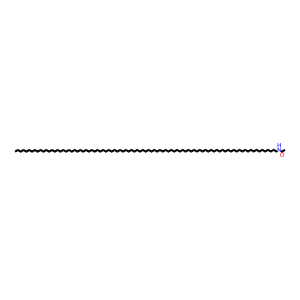

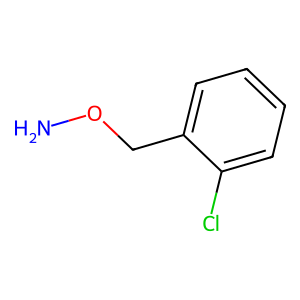

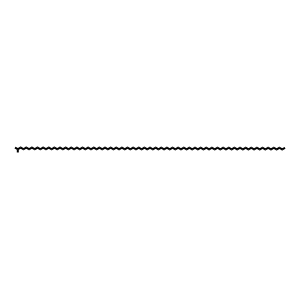

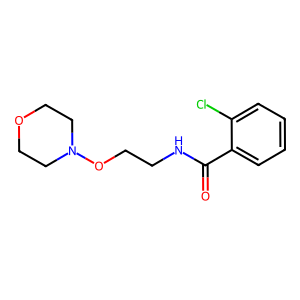

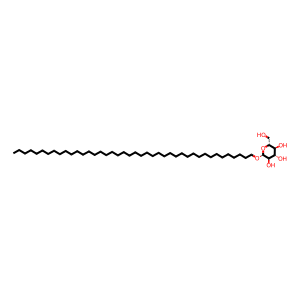

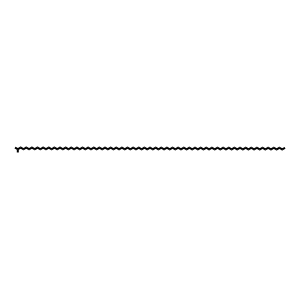

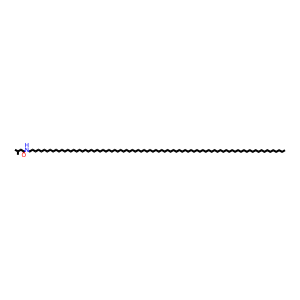

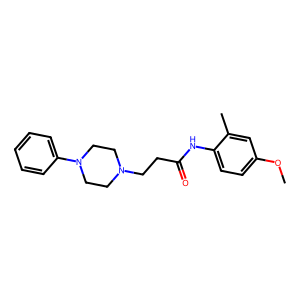

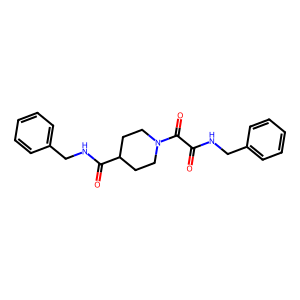

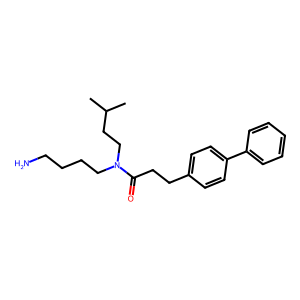

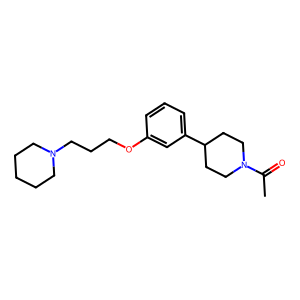

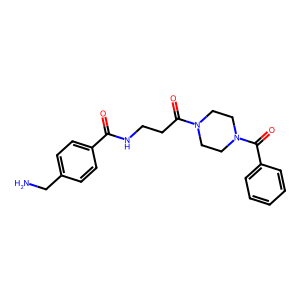

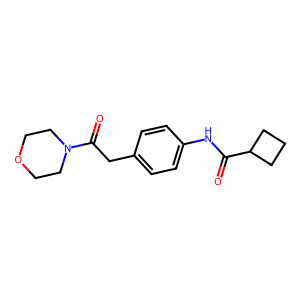

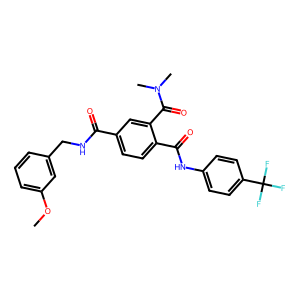

In [24]:
display(Markdown(f"# Generated {n_valid} valid and {n_invalid} invalid SMILES strings out of 5 attempts."))
display(Markdown("## Generated Molecules"))
for img in images:
    display(img)

## Generating random molecules is fun, but a real example of where this sort of model might be useful would be the generation of molecules with specific properties...

In other models, we'll work to condition the initial state of the model with a vector of desired properties extracted from CHEMBL, but for now, we could say that we hope to generate _variants_ of an existing molecule, but with random, physically plausible changes to the structure.

Lets take caffiene, every scientists favourit, without it no work would get done. It is described by the following SMILES string `CN1C=NC2=C1C(=O)N(C(=O)N2C)C`.

We can generate a series of caffiene-like molecules by providing the model with a portion of the caffiene SMILES and asking it to predict the next character in the SMILES string.

In [34]:
n_chars = 100

n_valid = 0
n_invalid = 0
images = []
for i in range(20):
    output = simple_rnn.simple_generate("CN1C=NC2=C1C(=O)N", n_chars, model, chembl.char_to_idx, chembl.idx_to_char, temperature=0.8, device='cuda')
    print(f"Requested up to {n_chars} characters, got: {len(output)}")
    print(f"Molecule Canonical SMILES: {output}")

    valid = utilities.validate_smiles_string(output)

    if not valid:
        n_invalid += 1
        print("Generated SMILES is not valid.")
    else:
        n_valid += 1
        print("Generated SMILES is valid.")
        images.append(utilities.draw_molecule(output))

Requested up to 100 characters, got: 30
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(CCN)C2=CC2=O
Generated SMILES is not valid.


[09:35:59] SMILES Parse Error: unclosed ring for input: 'CN1C=NC2=C1C(=O)N(CCN)C2=CC2=O'


Requested up to 100 characters, got: 96
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(CC(=O)N[C@H](CC(=O)Nc3ccc(OCc4ccccc4)cc3)c3ccccc3)C(=O)N1C=C2C(=O)c2ccccc2C1=O
Generated SMILES is valid.
Requested up to 100 characters, got: 19
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N13
Generated SMILES is not valid.
Requested up to 100 characters, got: 42
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(CCCc3ccccc3)c3ccccc3C2=O
Generated SMILES is valid.
Requested up to 100 characters, got: 32
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N1CCCC1)C1CCCCC1
Generated SMILES is not valid.


[09:35:59] SMILES Parse Error: unclosed ring for input: 'CN1C=NC2=C1C(=O)N13'
[09:35:59] SMILES Parse Error: extra close parentheses while parsing: CN1C=NC2=C1C(=O)N1CCCC1)C1CCCCC1
[09:35:59] SMILES Parse Error: check for mistakes around position 24:
[09:35:59] C=NC2=C1C(=O)N1CCCC1)C1CCCCC1
[09:35:59] ~~~~~~~~~~~~~~~~~~~~^
[09:35:59] SMILES Parse Error: Failed parsing SMILES 'CN1C=NC2=C1C(=O)N1CCCC1)C1CCCCC1' for input: 'CN1C=NC2=C1C(=O)N1CCCC1)C1CCCCC1'


Requested up to 100 characters, got: 42
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(CC(=O)Nc3ccc(Cl)nc3)C2=O
Generated SMILES is valid.
Requested up to 100 characters, got: 37
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)NC1(c1ccccc1)c1ccccc1
Generated SMILES is not valid.
Requested up to 100 characters, got: 33
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)NC(C(N)=O)C(=O)O2
Generated SMILES is valid.
Requested up to 100 characters, got: 39
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)NC(=O)[C@]2(O)C[C@@H]2O
Generated SMILES is not valid.


[09:35:59] SMILES Parse Error: ring closure 1 duplicates bond between atom 9 and atom 10 for input: 'CN1C=NC2=C1C(=O)NC1(c1ccccc1)c1ccccc1'
[09:35:59] SMILES Parse Error: unclosed ring for input: 'CN1C=NC2=C1C(=O)NC(=O)[C@]2(O)C[C@@H]2O'


Requested up to 100 characters, got: 36
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(c3ccccc3)C(=O)CC2C
Generated SMILES is valid.
Requested up to 100 characters, got: 83
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)NC(NC(=O)c3ccccc3)c2ccc(OCc3ccccc3)cc21)C(=O)N2CCC(Oc2ccc(F)cc2)CC1
Generated SMILES is not valid.
Requested up to 100 characters, got: 29
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N[C@@H](CO)C2
Generated SMILES is valid.


[09:36:00] SMILES Parse Error: extra close parentheses while parsing: CN1C=NC2=C1C(=O)NC(NC(=O)c3ccccc3)c2ccc(OCc3ccccc3)cc21)C(=O)N2CCC(Oc2ccc(F)cc2)CC1
[09:36:00] SMILES Parse Error: check for mistakes around position 56:
[09:36:00] 2ccc(OCc3ccccc3)cc21)C(=O)N2CCC(Oc2ccc(F)
[09:36:00] ~~~~~~~~~~~~~~~~~~~~^
[09:36:00] SMILES Parse Error: Failed parsing SMILES 'CN1C=NC2=C1C(=O)NC(NC(=O)c3ccccc3)c2ccc(OCc3ccccc3)cc21)C(=O)N2CCC(Oc2ccc(F)cc2)CC1' for input: 'CN1C=NC2=C1C(=O)NC(NC(=O)c3ccccc3)c2ccc(OCc3ccccc3)cc21)C(=O)N2CCC(Oc2ccc(F)cc2)CC1'


Requested up to 100 characters, got: 90
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(NC[C@@H](Nc1ccc(Cl)cc1)c(=O)c(F)ccc12)C(=O)NCCCCNC(=O)c1c(Cl)cc(Cl)cc1Cl
Generated SMILES is not valid.


[09:36:00] SMILES Parse Error: unclosed ring for input: 'CN1C=NC2=C1C(=O)N(NC[C@@H](Nc1ccc(Cl)cc1)c(=O)c(F)ccc12)C(=O)NCCCCNC(=O)c1c(Cl)cc(Cl)cc1Cl'


Requested up to 100 characters, got: 87
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N/C(=C/c2cccs2)C(=O)O1)c1ccccc1.CCSCCCN=C(N)N)=N/OC(=O)COc1ccc2ncccc2c1
Generated SMILES is not valid.
Requested up to 100 characters, got: 37
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(CN2CCCC[C@H]3O)C1=O
Generated SMILES is not valid.
Requested up to 100 characters, got: 35
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(c3cccc(OC)c3)C2=O
Generated SMILES is valid.
Requested up to 100 characters, got: 38
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(CCO)c2cc3c(cc21)OCO3
Generated SMILES is not valid.


[09:36:00] SMILES Parse Error: extra close parentheses while parsing: CN1C=NC2=C1C(=O)N/C(=C/c2cccs2)C(=O)O1)c1ccccc1.CCSCCCN=C(N)N)=N/OC(=O)COc1ccc2ncccc2c1
[09:36:00] SMILES Parse Error: check for mistakes around position 39:
[09:36:00] C(=C/c2cccs2)C(=O)O1)c1ccccc1.CCSCCCN=C(N
[09:36:00] ~~~~~~~~~~~~~~~~~~~~^
[09:36:00] SMILES Parse Error: Failed parsing SMILES 'CN1C=NC2=C1C(=O)N/C(=C/c2cccs2)C(=O)O1)c1ccccc1.CCSCCCN=C(N)N)=N/OC(=O)COc1ccc2ncccc2c1' for input: 'CN1C=NC2=C1C(=O)N/C(=C/c2cccs2)C(=O)O1)c1ccccc1.CCSCCCN=C(N)N)=N/OC(=O)COc1ccc2ncccc2c1'
[09:36:00] SMILES Parse Error: unclosed ring for input: 'CN1C=NC2=C1C(=O)N(CN2CCCC[C@H]3O)C1=O'
[09:36:01] SMILES Parse Error: unclosed ring for input: 'CN1C=NC2=C1C(=O)N(CCO)c2cc3c(cc21)OCO3'


Requested up to 100 characters, got: 30
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)NC2C2CCCCC2)c1
Generated SMILES is not valid.
Requested up to 100 characters, got: 41
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N(OC(=O)c1ccccc1)c1ccccc1
Generated SMILES is not valid.
Requested up to 100 characters, got: 45
Molecule Canonical SMILES: CN1C=NC2=C1C(=O)N/N=C(/C(=O)Nc3ccccc3)C2=O)c1
Generated SMILES is not valid.


[09:36:01] SMILES Parse Error: extra close parentheses while parsing: CN1C=NC2=C1C(=O)NC2C2CCCCC2)c1
[09:36:01] SMILES Parse Error: check for mistakes around position 28:
[09:36:01] 2=C1C(=O)NC2C2CCCCC2)c1
[09:36:01] ~~~~~~~~~~~~~~~~~~~~^
[09:36:01] SMILES Parse Error: Failed parsing SMILES 'CN1C=NC2=C1C(=O)NC2C2CCCCC2)c1' for input: 'CN1C=NC2=C1C(=O)NC2C2CCCCC2)c1'
[09:36:01] SMILES Parse Error: unclosed ring for input: 'CN1C=NC2=C1C(=O)N(OC(=O)c1ccccc1)c1ccccc1'
[09:36:01] SMILES Parse Error: extra close parentheses while parsing: CN1C=NC2=C1C(=O)N/N=C(/C(=O)Nc3ccccc3)C2=O)c1
[09:36:01] SMILES Parse Error: check for mistakes around position 43:
[09:36:01] /C(=O)Nc3ccccc3)C2=O)c1
[09:36:01] ~~~~~~~~~~~~~~~~~~~~^
[09:36:01] SMILES Parse Error: Failed parsing SMILES 'CN1C=NC2=C1C(=O)N/N=C(/C(=O)Nc3ccccc3)C2=O)c1' for input: 'CN1C=NC2=C1C(=O)N/N=C(/C(=O)Nc3ccccc3)C2=O)c1'


# Generated 7 valid caffiene-like molecules and 13 invalid SMILES strings out of 5 attempts.

## Generated Molecules

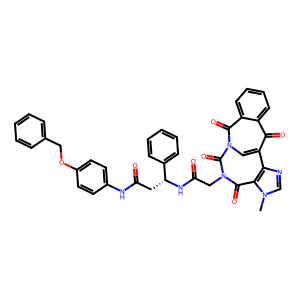

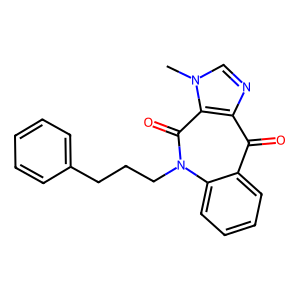

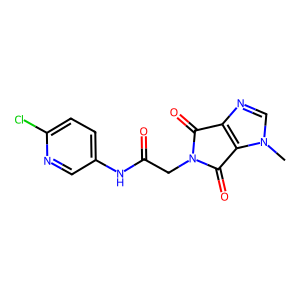

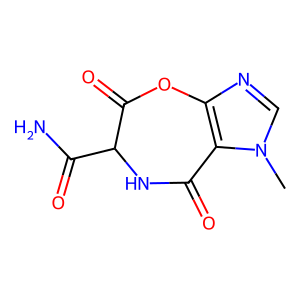

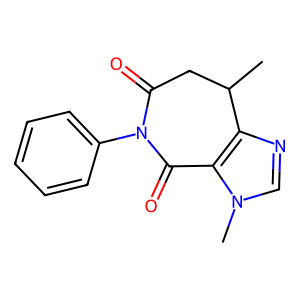

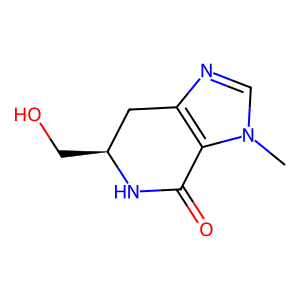

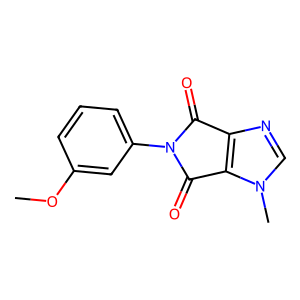

In [35]:
display(Markdown(f"# Generated {n_valid} valid caffiene-like molecules and {n_invalid} invalid SMILES strings out of 5 attempts."))
display(Markdown("## Generated Molecules"))
for img in images:
    display(img)